# Part 1 Hog Feature Vector

Write a program to implement the Histogram of Orientated Gradients (HOG) Algorithm for
pedestrian detection. The dataset used to evaluate the descriptor is “NICTA Pedestrian
Dataset,” where it contains both the training set and the testing set. The training set contains
1000 positives samples (images contain pedestrians) and 2000 negatives samples (images do
not contain pedestrians). The testing set includes 500 positive samples and 500 negative
samples. Resize all images to 64 × 128 and use the following set of parameters:
• Cell size [8 8]
• Block size [ 16 16]
• Gradient operators: Gx= [-1 0 1] and Gy= [-1 0 1]T
• Number of orientation bins = 9


## What is a Feature Descriptor ?

A feature descriptor is a representation of an image or an image patch that simplifies the image by extracting useful 
information and throwing away extraneous information.
Typically, a feature descriptor converts an image of size widthxheightx3 (channels) to a feature vector / array of length n. 
In the case of the HOG feature descriptor,the input image is of size 64 x 128 x 3 and the output feature vector is 
of length 3780.

### Flow chart

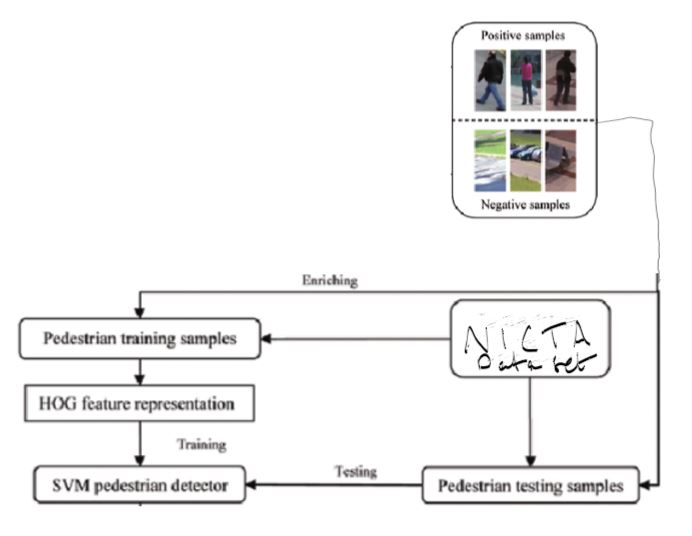

In [1]:
from IPython.display import Image
Image(filename='flowchart.jpg') 

## How to calculate Histogram of Oriented Gradients ?

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as iread
from PIL import Image
import numpy as np

In [9]:
#for sliding window for calculating histogram
cell = [8, 8]
incr = [8,8]
bin_num = 9
im_size = [64,128]

### Step 1 : Loading Preprocessing
As mentioned earlier HOG feature descriptor used for pedestrian detection is calculated on a 64×128 patch of an image. 
Of course, an image may be of any size. Typically patches at multiple scales are analyzed at many image locations.
The only constraint is that the patches being analyzed have a fixed aspect ratio

In [10]:
def create_array(image_path):
        img = Image.open(image_path).convert('L')
        image_array = np.asarray(img,dtype=float)
        return image_array

### Step 2 : Calculate the Gradient Images
To calculate a HOG descriptor, we need to first calculate the horizontal and vertical gradients; after all,
we want to calculate the histogram of gradients. This is easily achieved by filtering the image with the following kernels.

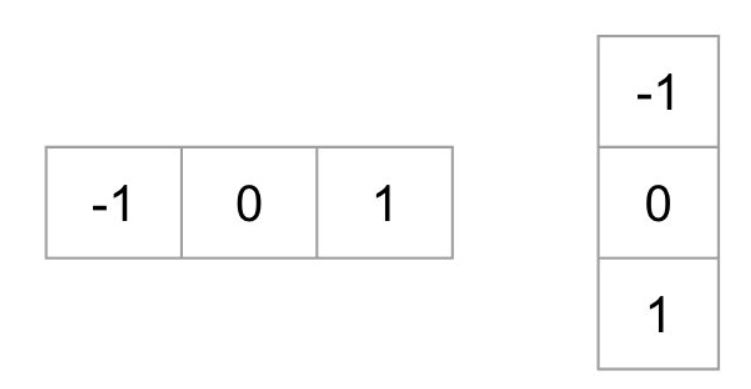

In [47]:
from IPython.display import Image
Image(filename='kernel.jpg') 

### Step 3: Calculating Gradients (direction x and y)

The next step is to calculate the gradient for every pixel in the image.Gradients are the small change in the x and y directions.
Here, I am going to take a small patch from the image and calculate the gradients on that:

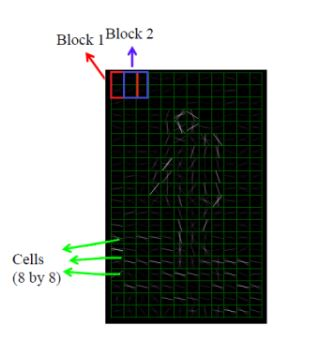

In [40]:
from IPython.display import Image
Image(filename='Blocks_cells.jpg') 

we can find the magnitude and direction of gradient using the following formula

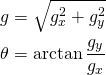

In [41]:
from IPython.display import Image
Image(filename='g_m.png') 

In [11]:
#uses a [-1 0 1 kernel]

def create_grad_array(image_array):
        image_array = Image.fromarray(image_array)
        if not image_array.size == im_size:
             image_array = image_array.resize(im_size, resample=Image.BICUBIC)
        image_array = np.asarray(image_array,dtype=float)

        # gamma correction
        image_array = (image_array)**2.5
        
        # local contrast normalisation
        image_array = (image_array-np.mean(image_array))/np.std(image_array)
        max_h = 128
        max_w = 64
        grad = np.zeros([max_h, max_w])
        mag = np.zeros([max_h, max_w])
        for h,row in enumerate(image_array):
                for w, val in enumerate(row):
                       if h-1>=0 and w-1>=0 and h+1<max_h and w+1<max_w:
                                dy = image_array[h+1][w]-image_array[h-1][w]
                                dx = row[w+1]-row[w-1]+0.0001
                                grad[h][w] = np.arctan(dy/dx)*(180/np.pi)
                                if grad[h][w]<0:
                                     grad[h][w] += 180
                                mag[h][w] = np.sqrt(dy*dy+dx*dx)

        return grad,mag

### Step 4: Calculate Histogram of Gradients in 8×8 cells (9×1)
The histograms created in the HOG feature descriptor are not generated for the whole image. Instead, the image is divided into 8×8 cells, and the histogram of oriented gradients is computed for each cell. Why do you think this happens? 
By doing so, we get the features (or histogram) for the smaller patches which in turn represent the whole image. We can certainly change this value here from 8 x 8 to 16 x 16 or 32 x 32. 

Let us start with the simplest way to generate histograms. We will take each pixel value, find the orientation of the pixel and update the frequency table. 

So, the number of buckets we would get here is 9. 
Again, for each pixel, we will check the orientation, and store the frequency of the orientation values in the form of a 9 x 1 matrix. Plotting this would give us the histogram: 

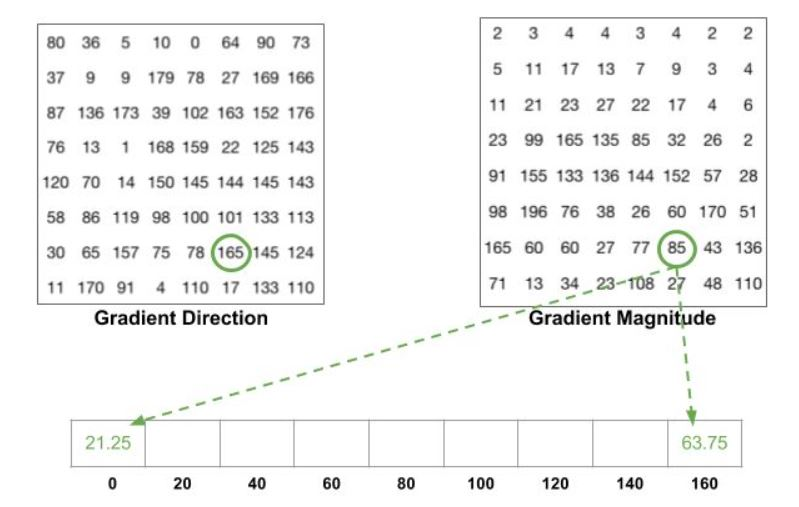

In [44]:
from IPython.display import Image
Image(filename='hist.jpg') 

In [12]:
def calculate_histogram(array,weights):
    bins_range = (0, 180)
    bins = bin_num
    hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)
    return hist

## Step 5: Normalize gradients in 16×16 cell (36×1)
Before we understand how this is done, it’s important to understand why this is done in the first place. 
Although we already have the HOG features created for the 8×8 cells of the image, the gradients of the image are sensitive to the overall lighting. This means that for a particular picture, some portion of the image would be very bright as compared to the other portions. 
We cannot completely eliminate this from the image. But we can reduce this lighting variation by normalizing the gradients by taking 16×16 blocks. Here is an example that can explain how 16×16 blocks are created:

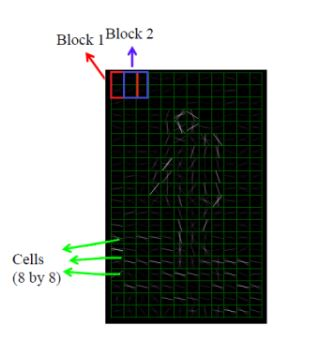

In [43]:
from IPython.display import Image
Image(filename='Blocks_cells.jpg') 


### Block Normalization
In this firstly we have to make a block of cells as we did in building cells of pixels. In the end, we have to normalize the blocks. Now you must be thinking why this normalization???
 
Well!! Just imagine that you have one image in less lightning and another one in more lighting. The gradient values will be different for sure in both the images. So to avoid this situation, we use the normalization of blocks.
 
### Now how it is done??
We have a 9*1 vector of a histogram. Now we have to normalize a block that is, 16*16 pixels. This one block comprises 4 histograms which when concatenated will form 36*1. This is how the 36*1 vector is calculated from this window.

In [13]:
def create_hog_features(grad_array,mag_array):

    max_h = int(((grad_array.shape[0]-cell[0])/incr[0])+1)
    max_w = int(((grad_array.shape[1]-cell[1])/incr[1])+1)
    cell_array = []
    w = 0
    h = 0
    i = 0
    j = 0
   
    #Creating 8X8 cells
    while i<max_h:
        w = 0
        j = 0
        
        while j<max_w:
                for_hist = grad_array[h:h+cell[0],w:w+cell[1]]
                for_wght = mag_array[h:h+cell[0],w:w+cell[1]]
                val = calculate_histogram(for_hist,for_wght)
                cell_array.append(val)
                j += 1
                w += incr[1]
        i += 1
        h += incr[0]



    cell_array = np.reshape(cell_array,(max_h, max_w, bin_num))
    #normalising blocks of cells
    block = [2,2]
    #here increment is 1
    max_h = int((max_h-block[0])+1)
    max_w = int((max_w-block[1])+1)
    block_list = []
    w = 0
    h = 0
    i = 0
    j = 0
    while i<max_h:
        w = 0

        j = 0
        while j<max_w:
            for_norm = cell_array[h:h+block[0],w:w+block[1]]
            mag = np.linalg.norm(for_norm)
            arr_list = (for_norm/mag).flatten().tolist()
            block_list += arr_list
            j += 1
            w += 1
        i += 1
        h += 1
#returns a vextor array list of 288 elements

    return block_list

### Calculate the HOG(Histogram Of Oriented Gradients) Feature Vector
The final feature vector of Histogram Of Oriented Gradients will be calculated by the concatenation of feature vectors of all blocks in an image. So, in the end, we will receive a giant vector of features. 
 
And this is how features of an image are calculated using HOG. There are many methods of feature extraction but this extracts features using the gradient which makes it different from others. 

In [14]:
#image_array must be an array

#returns a features vector from image array

def apply_hog(image_array):
    gradient,magnitude = create_grad_array(image_array)
    hog_features = create_hog_features(gradient,magnitude)
    hog_features = np.asarray(hog_features,dtype=float)
    hog_features = np.expand_dims(hog_features,axis=0)
    return hog_features

In [15]:
#path must be image path

#returns final features array from image_path

def find_hog(image_path):
    image_array = create_array(image_path)
    final_array = apply_hog(image_array)
    return final_array

Example of feature vector generated

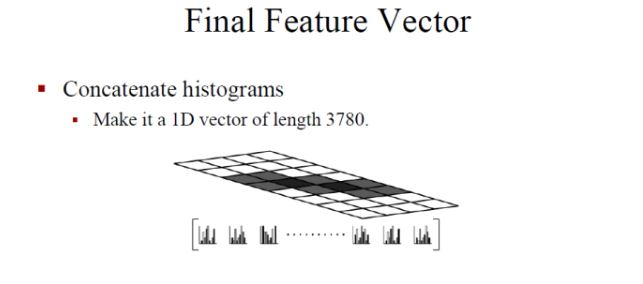

In [45]:
from IPython.display import Image
Image(filename='feature.jpg') 

In [16]:
find_hog(r"C:\Users\atche\Desktop\Study zone\AI\Project 4\NICTA\TrainSet\PositiveSamples\item_00000089.pnm")

array([[0.03809698, 0.08651973, 0.01932677, ..., 0.00112765, 0.0017499 ,
        0.        ]])

We would have 105 (7×15) blocks of 16×16. Each of these 105 blocks has a vector of 36×1 as features. Hence, the total features for the image would be 105 x 36×1 = 3780 features. 

In [17]:
x=find_hog(r"C:\Users\atche\Desktop\Study zone\AI\Project 4\NICTA\TrainSet\PositiveSamples\item_00000089.pnm")
print('Length of the vector is ')
len(x[0])

Length of the vector is 


3780

# Part 2 SVM Implementation
Write a program to train and test the linear Support Vector Machine (SVM) classifier for pedestrian detection using the extracted features from part 1. 

## a) Train the SVM classifier with HOG features of the training set (use built-infunction/library (e.g. from sklearn.svm import SVC)).

In [23]:
# Importing the necessary modules:


from skimage.transform import pyramid_gaussian

from skimage.io import imread

from sklearn.externals import joblib

from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from skimage import color

from imutils.object_detection import non_max_suppression

import imutils

import numpy as np

import argparse

import cv2

import os

import glob

from PIL import Image # This will be used to read/modify images (can be done via OpenCV too)

from numpy import *
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [24]:
# define path to images:

# This is the path of our positive input dataset
pos_im_path = r"NICTA\TrainSet\PositiveSamples" 

# define the same for negatives
neg_im_path= r"NICTA\TrainSet\NegativeSamples"

In [25]:
# read the image files:


pos_im_listing = os.listdir(pos_im_path) # it will read all the files in the positive image path (so all the required images)
neg_im_listing = os.listdir(neg_im_path)
num_pos_samples = size(pos_im_listing) # simply states the total no. of images
num_neg_samples = size(neg_im_listing)

print('training data :')
print('No. of positive samples  '+str(num_pos_samples))# prints the number value of the no.of samples in positive dataset
print('No. of Negative samples  '+str(num_neg_samples))

data= []
labels = []

training data :
No. of positive samples  999
No. of Negative samples  2000


In [26]:
# compute HOG features and label them:


for file in pos_im_listing: #this loop enables reading the files in the pos_im_listing variable one by one

    '''
    img = Image.open(pos_im_path + '\\' + file) # open the file
    img = img.resize((64,128))
    gray = img.convert('L') # convert the image into single channel i.e. RGB to grayscale
    '''
    
    # calculate HOG for positive features
    path = pos_im_path + '\\' + file
    fd = find_hog(path)
    data.append(fd)

    labels.append(1)

The list of feature vectors

In [31]:
# Same for the negative images

for file in neg_im_listing:
    '''
    img= Image.open(neg_im_path + '\\' + file)
    img = img.resize((64,128))
    gray= img.convert('L')
    '''
    
    path = neg_im_path + '\\' + file
    # Now we calculate the HOG for negative features
    fd = find_hog(path) 
    data.append(fd)
    labels.append(0)

In [32]:
da = []

for i in range(0,len(data)):
    p = np.array(data[i])
    #removing some nan values
    if np.isnan(p[0][0]):
        data[i] = data[i-1]
for x in data:
    da.append(x.flatten())

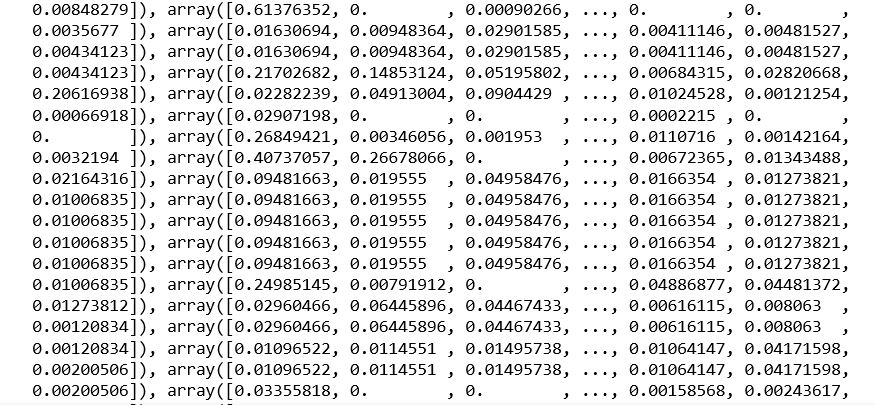

In [46]:
from IPython.display import Image
Image(filename='list.jpg') 

In [33]:
# encode the labels, converting them from strings to integers
le = LabelEncoder()
labels = le.fit_transform(labels)

## b) Classify the HOG features of the testing images (both positive and negatives samples) using the trained SVM model (use built-in function/library).

In [34]:
#Applying hog and labeling the test data
# define path to images:

# This is the path of our positive input dataset
pos_im_path = r"NICTA\TestSet\PositiveSamples" 

# define the same for negatives
neg_im_path= r"NICTA\TestSet\NegativeSamples"

# read the image files:


pos_im_listing = os.listdir(pos_im_path) # it will read all the files in the positive image path (so all the required images)
neg_im_listing = os.listdir(neg_im_path)
num_pos_samples = size(pos_im_listing) # simply states the total no. of images
num_neg_samples = size(neg_im_listing)

print('Test Data details :')
print('No. of positive samples  '+str(num_pos_samples))# prints the number value of the no.of samples in positive dataset
print('No. of Negative samples  '+str(num_neg_samples))

test_data= []
test_labels = []

# compute HOG features and label them:


for file in pos_im_listing: #this loop enables reading the files in the pos_im_listing variable one by one

    '''
    img = Image.open(pos_im_path + '\\' + file) # open the file
    img = img.resize((64,128))
    gray = img.convert('L') # convert the image into single channel i.e. RGB to grayscale
    '''
    
    # calculate HOG for positive features
    path = pos_im_path + '\\' + file
    fd = find_hog(path)
    test_data.append(fd)

    test_labels.append(1)
    
# Same for the negative images

for file in neg_im_listing:
    '''
    img= Image.open(neg_im_path + '\\' + file)
    img = img.resize((64,128))
    gray= img.convert('L')
    '''
    
    path = neg_im_path + '\\' + file
    # Now we calculate the HOG for negative features
    fd = find_hog(path) 
    test_data.append(fd)
    test_labels.append(0)
    
d = []
for i in range(0,len(test_data)):
    p = np.array(test_data[i])
    if np.isnan(p[0][0]):
        test_data[i] = test_data[i-1]
for x in test_data:
    d.append(x.flatten())


Test Data details :
No. of positive samples  500
No. of Negative samples  500


In [65]:
# encode the labels, converting them from strings to integers
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

## c) Compute the accuracy, false positive rate, and the miss rate. 

In [75]:
from sklearn.metrics import confusion_matrix

print(" Constructing training/testing split...")

#(trainData, testData, trainLabels, testLabels) = train_test_split(da, labels, test_size=0.20, random_state=42)

trainData = da
testData = d
trainLabels = labels
testLabels = test_labels
#%% Train the linear SVM

print(" Training Linear SVM classifier...")

model = LinearSVC()

model.fit(trainData, trainLabels)

#%% Evaluate the classifier

print(" Evaluating classifier on test data ...")

predictions = model.predict(testData)

print(classification_report(testLabels, predictions))

    
#accuracy = accuracy_score(y_test,y_pred)
C = confusion_matrix(testLabels,predictions)
print('Confusion Matrix:')
print(C)
TN = C[0][0]
FN = C[1][0]
TP = C[1][1]
FP = C[0][1]
accuracy = (TP + TP)/1000

FP_rate = FP / (FP + TN)
miss_rate = 1 - accuracy
print("Accuracy:",accuracy)
print("False Positive Rate:", FP_rate)
print("Miss Rate:",miss_rate)


 Constructing training/testing split...
 Training Linear SVM classifier...
 Evaluating classifier on test data ...
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       500
           1       0.99      0.96      0.97       500

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.97      0.97      1000

Confusion Matrix:
[[493   7]
 [ 18 482]]
Accuracy: 0.964
False Positive Rate: 0.014
Miss Rate: 0.03600000000000003


C:\Users\atche\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Part 3 Others Kernel
Repeat the experiment in part 2 for training the SVM classifier with different set of kernel
functions (e. g. rbf, polynomial, etc.). 

## used rbf & sigmoid

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

trainData = da
testData = d
trainLabels = labels
testLabels = test_labels

svm = SVC(kernel='rbf', gamma='auto')
svm.fit(trainData, trainLabels)

predicted = svm.predict(testData)

cm = confusion_matrix(testLabels, predicted)
print('Confusion Matrix:')
print(cm)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
accuracy = (TP + TP)/1000

FP_rate = FP / (FP + TN)
miss_rate = 1 - accuracy
print("Accuracy:",accuracy)
print("False Positive Rate:", FP_rate)
print("Miss Rate:",miss_rate)


Confusion Matrix:
[[485  15]
 [ 31 469]]
Accuracy: 0.938
False Positive Rate: 0.03
Miss Rate: 0.062000000000000055


In [39]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

trainData = da
testData = d
trainLabels = labels
testLabels = test_labels

svm = SVC(kernel='sigmoid', gamma = 'auto')
svm.fit(trainData, trainLabels)

predicted = svm.predict(testData)

cm = confusion_matrix(testLabels, predicted)
print('Confusion Matrix:')
print(cm)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
accuracy = (TP + TP)/1000

FP_rate = FP / (FP + TN)
miss_rate = 1 - accuracy
print("Accuracy:",accuracy)
print("False Positive Rate:", FP_rate)
print("Miss Rate:",miss_rate)


Confusion Matrix:
[[483  17]
 [ 49 451]]
Accuracy: 0.902
False Positive Rate: 0.034
Miss Rate: 0.09799999999999998
